In [3]:
!pip install tensorflow opencv-python matplotlib

  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-win_amd64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.1-cp311-cp311-win_amd64.whl (126 kB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2


In [7]:
import tensorflow as tf
import os
gpus = tf.config.experimental.list_physical_devices('GPU') #limiting GPU consumption(avoiding OOM errors)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
import cv2
import imghdr

C:\Users\APOORV\AppData\Local\Temp\ipykernel_11508\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [9]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'png', 'bmp']

In [11]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with Image {}'.format(image_path))
                

In [47]:
import numpy as np
import matplotlib.pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('data')
data

Found 305 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x0000021CF914F510>)

In [37]:
#batch = data_iterator.next()

In [38]:
#batch[0].shape #images as numpy arrays

(32, 256, 256, 3)

In [39]:
#batch[1] #labels
#after running we see class 1 - SAD, class 0 - Happy

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0])

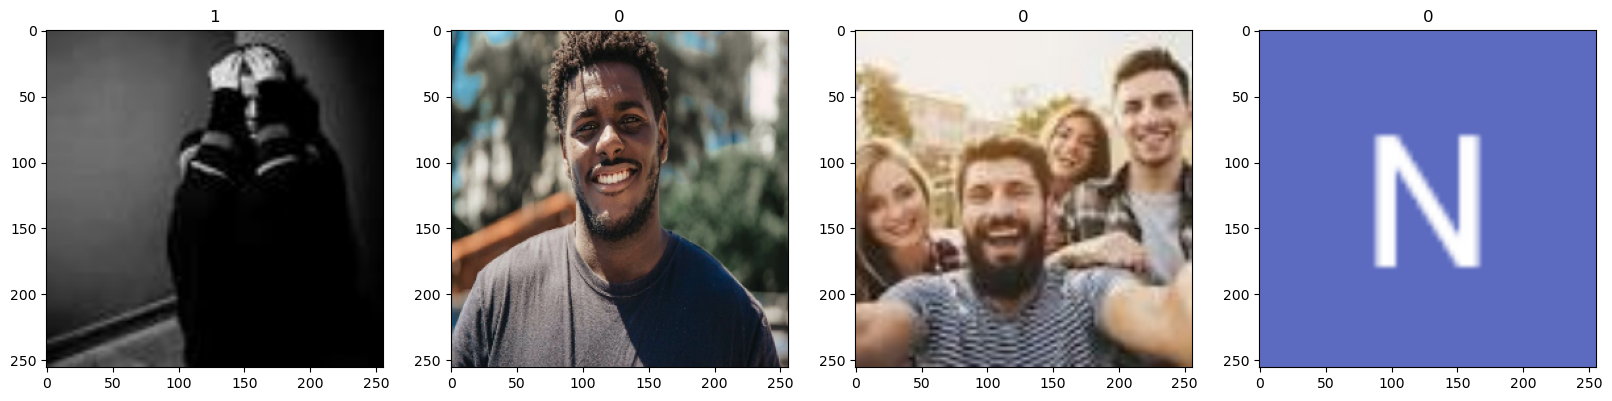

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [43]:
#normalize/scale the data
# scaled = batch[0] / 255
# scaled.max()
#but this would take more compute as everytime we load data into pipeline

1.5378702e-05

In [48]:
data = data.map(lambda x,y: (x/255, y)) #so we changed the data as it goes into the pipeline
# After loading data run this directly

In [49]:
scaled_iterator = data.as_numpy_iterator()

In [50]:
batch = scaled_iterator.next()
batch[0].max()

1.0

In [51]:
len(data)

10

In [52]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [53]:
val_size

2

In [54]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [55]:
len(train)

7

In [56]:
# Build Deep Learning Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [62]:
model = Sequential()

In [63]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #input layer
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [64]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Train

In [67]:
logdir = 'logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.4836 - loss: 0.9387 - val_accuracy: 0.6094 - val_loss: 0.6903
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 819ms/step - accuracy: 0.6015 - loss: 0.6829 - val_accuracy: 0.5312 - val_loss: 0.6594
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 719ms/step - accuracy: 0.6674 - loss: 0.6240 - val_accuracy: 0.7500 - val_loss: 0.5526
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 776ms/step - accuracy: 0.7705 - loss: 0.5054 - val_accuracy: 0.7812 - val_loss: 0.4565
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 727ms/step - accuracy: 0.8562 - loss: 0.4576 - val_accuracy: 0.8594 - val_loss: 0.4651
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 759ms/step - accuracy: 0.9211 - loss: 0.3515 - val_accuracy: 0.8438 - val_loss: 0.3998
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 830ms/step - accuracy: 0.8850 - loss: 0.2960 - val_accuracy: 0.9062 - val_loss: 0.3145
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 714ms/step - accuracy: 0.8942 - loss: 0.2912 - val_accuracy: 0.9531 - val_loss: 0

In [70]:
hist.history

{'accuracy': [0.4866071343421936,
  0.625,
  0.7053571343421936,
  0.7455357313156128,
  0.8303571343421936,
  0.9017857313156128,
  0.9017857313156128,
  0.9285714030265808,
  0.9553571343421936,
  0.9866071343421936,
  0.96875,
  0.96875,
  0.9732142686843872,
  0.9910714030265808,
  0.9910714030265808,
  0.9910714030265808,
  0.9955357313156128,
  0.9910714030265808,
  0.9955357313156128,
  0.9910714030265808],
 'loss': [0.8790400624275208,
  0.6774935126304626,
  0.6008462905883789,
  0.5328008532524109,
  0.4520602226257324,
  0.3577301800251007,
  0.2960379719734192,
  0.22822058200836182,
  0.1609790325164795,
  0.09115464240312576,
  0.09001994132995605,
  0.11470271646976471,
  0.08796602487564087,
  0.055118728429079056,
  0.04269852861762047,
  0.04375128075480461,
  0.033524420112371445,
  0.037148814648389816,
  0.015534109435975552,
  0.021205846220254898],
 'val_accuracy': [0.609375,
  0.53125,
  0.75,
  0.78125,
  0.859375,
  0.84375,
  0.90625,
  0.953125,
  0.9375,
  

In [71]:
# Plotting Performance

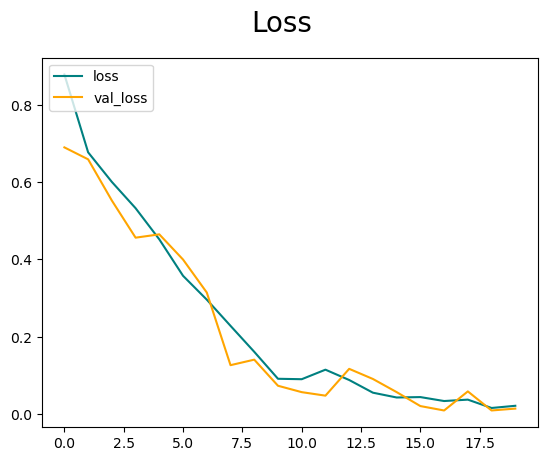

In [72]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

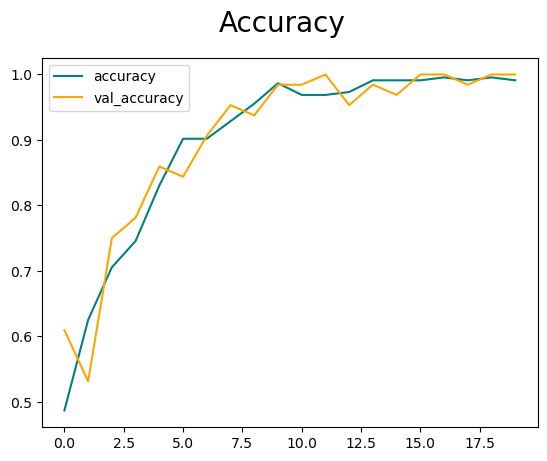

In [73]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [74]:
# Performance Tests

In [75]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [76]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [77]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


In [78]:
print(f'Presicison:{pre.result().numpy()}, Recall:{re.result().numpy()}. Accuracy:{acc.result().numpy()}')

Presicison:1.0, Recall:1.0. Accuracy:1.0


In [79]:
# Testing

#load any image which this model has never seen before and test on it

In [80]:
# Saving the model

In [81]:
from tensorflow.keras.models import load_model

In [82]:
model.save(os.path.join('models', 'happysadclassification.h5'))